In [ ]:
# analyzing SBC amyloid, microglia after RLP treatment (blind)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import wesanderson
import os
import re
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
def get_tiny_df(file_path, cols, batch, iid_channel):
    """
    Returns a df with one row, corresponding to the amyloid/microglia/astrocyte
    data for a single image.
    """
    
    df = pd.read_csv(file_path, header=2, index_col=0)
    idx = re.search(r'\d+_?[MF]_?sliceC(\d+)', file_path).group(0)
    gender = 'M' if '_M_' in idx else 'F'

    if iid_channel is None:
        # just get the volume and area
        vol = df.loc['Volume']['Sum']
        area = df.loc['Area']['Sum']
        vals = [idx, gender, batch, vol, area]
        
    else:
        # get surface, iid data
        num_cells = df.loc['Number of Disconnected Components']['Count']
        vol = df.loc['Volume']['Sum']
        sa = df.loc['Area']['Sum']
    
        df = df[df['Channel'] == iid_channel]
        mean_iid = df.loc['Intensity Sum']['Mean']
        sum_iid = df.loc['Intensity Sum']['Sum']

        vals = [idx, gender, batch, num_cells, vol, sa, sum_iid]

    return pd.DataFrame([vals], columns=cols)


def get_big_df(direc, cols, batch, iid_channel=None):
    """
    Returns a df with the amyloid/microglia/astrocyte data for all images in
    a directory.
    """
    
    files = [os.path.join(direc, f) for f in os.listdir(direc)]
    dfs = [get_tiny_df(file_path, cols, batch, iid_channel) for file_path in files]
    
    return pd.concat(dfs, ignore_index=True)


def join_dfs(dfs, sofar=None):
    """
    Inner joins a list of dfs on 'ID' and 'Gender'.
    """

    if sofar is None:
        sofar = dfs[0]
        dfs = dfs[1:]

    if len(dfs) == 0:
        return sofar

    else:
        merged_df = pd.merge(sofar, dfs[0], on=['ID', 'Gender', 'Batch'], how='inner')
        return join_dfs(dfs[1:], merged_df)


def process_replicates(df):
    """
    Averages rows w/ technical replicates (same sample number, diff. slice).
    """

    def extract_base_id(id_str):
        match = re.match(r'(\d+_[MF])_', id_str)
        return match.group(1) if match else None

    df['Base_ID'] = df['ID'].apply(extract_base_id)

    non_numeric_cols = {'ID', 'Gender', 'Batch', 'Base_ID'}
    numeric_cols = [col for col in df.columns if col not in non_numeric_cols]

    # average together tech reps, numeric
    averaged = df.groupby('Base_ID')[numeric_cols].mean().reset_index()
    averaged['ID'] = averaged['Base_ID'] + '_AVG'

    # copy over non-numeric data
    meta_cols = ['Gender', 'Batch']
    meta_info = df.groupby('Base_ID')[meta_cols].first().reset_index()

    # merge and return
    averaged = averaged.merge(meta_info, on='Base_ID')
    final_cols = ['ID', 'Gender', 'Batch'] + numeric_cols
    return averaged[final_cols]

In [3]:
# all amyloid data

sbc_amyloid_dir = '../data/SBC data/sbc amyloid '
a_cols = ['ID', 'Gender', 'Batch', 'Amyloid Plaque Count', 'Amyloid Surface Volume', 'Amyloid Surface Area', 'Total Amyloid IID']
amyloid_batches = {'1-16': 7, '18-32': 7}

a_dfs = [get_big_df(sbc_amyloid_dir + batch, a_cols, batch, 7) for batch, channel in amyloid_batches.items()]
a_df = pd.concat(a_dfs, ignore_index=True)

In [4]:
# all microglia data

sbc_microglia_dir = '../data/SBC data/sbc microglia '
m_cols = ['ID', 'Gender', 'Batch', 'Microglia Count', 'Microglia Surface Volume', 'Microglia Surface Area', 'Total Microglia IID']
microglia_batches = {'1-16': 6, '18-32': 6}

m_dfs = [get_big_df(sbc_microglia_dir + batch, m_cols, batch, channel) for batch, channel in microglia_batches.items()]
m_df = pd.concat(m_dfs, ignore_index=True)

In [5]:
# all volume data

sbc_vol_dir = '../data/SBC Data/sbc volume '
vol_cols = ['ID', 'Gender', 'Batch', 'SBC Volume', 'SBC Area']

batches = ['1-16', '18-32'] # TODO: add '33-40'
vol_dfs = [get_big_df(sbc_vol_dir + batch, vol_cols, batch) for batch in batches]
vol_df = pd.concat(vol_dfs, ignore_index=True)

In [6]:
# all LD data

ld_df = pd.read_csv('../data/SBC Data/SBC LD/LD.csv')
ld_df.rename(columns={'Avg Vol': 'Avg LD Vol', 'Avg SA': 'Avg LD SA'}, inplace=True)

ld_df['ID'] = pd.Series(re.search(r'\d+_?[MF]_?sliceC(\d+)', filename).group(0) for filename in ld_df['Image'])
ld_df['Gender'] = pd.Series('M' if '_M_' in filename else 'F' for filename in ld_df['Image'])

first_num = ld_df['ID'].str.extract(r'^(\d+)', expand=False).astype(int)
ld_df['Batch'] = first_num.apply(lambda n: '1-16' if 1 <= n <= 16 else '18-32')

ld_df.drop('Image', axis=1, inplace=True)

In [7]:
sbc_df = join_dfs([a_df, m_df, vol_df, ld_df])
sbc_df.to_csv('sbc.csv')
sbc_df

,ID,Gender,Batch,Amyloid Plaque Count,Amyloid Surface Volume,Amyloid Surface Area,Total Amyloid IID,Microglia Count,Microglia Surface Volume,Microglia Surface Area,Total Microglia IID,SBC Volume,SBC Area,LD Count,Avg LD Vol,Avg LD SA,BODIPY IID
0,18_M_sliceC1,M,18-32,327,1273971.875,426848.750,3.709788e+10,529,973801.562,500464.781,3.355745e+10,11766215.0,649171.875,4868,1.6173,1.1243,2.927684e+10
1,18_M_sliceC2,M,18-32,274,1258034.500,400497.125,3.143661e+10,527,977902.625,498027.750,2.678518e+10,11944488.0,651053.750,5766,1.6335,1.1681,3.474955e+10
2,19_M_sliceC1,M,18-32,428,1653414.250,556115.250,4.025996e+10,772,1188402.875,642348.062,3.802840e+10,18143518.0,743465.875,18754,3.2354,3.2545,6.917332e+10
3,19_M_sliceC2,M,18-32,357,1642574.125,518506.969,4.468865e+10,643,1219405.000,652369.812,4.368731e+10,16856194.0,695881.812,19481,3.0157,2.9436,7.480645e+10
4,20_F_sliceC1,F,18-32,386,1653218.375,531813.188,4.307678e+10,686,1248745.875,661361.438,4.890265e+10,17870706.0,757438.500,16889,3.7085,3.9208,7.353428e+10
5,20_F_sliceC2,F,18-32,497,1588419.500,557448.062,3.816594e+10,804,1279435.875,701027.875,5.968837e+10,16478220.0,706263.000,14588,3.1180,3.3803,4.742930e+10
6,21_F_sliceC1,F,18-32,238,1166518.500,355062.031,2.021145e+10,464,1007809.938,520253.250,1.388636e+10,11723180.0,597171.688,3675,1.8562,1.5592,2.984792e+10
7,21_F_sliceC2,F,18-32,270,1197033.250,357271.031,1.709964e+10,494,986070.438,496881.875,1.106798e+10,11689112.0,594843.875,7479,2.0738,1.8023,5.636822e+10
8,22_F_sliceC1,F,18-32,469,2185575.000,688845.938,3.180777e+10,806,1516481.750,819007.562,4.791133e+10,18145308.0,605369.438,8088,2.4486,2.1016,8.492669e+10
9,22_F_sliceC2,F,18-32,539,2176076.000,719638.812,3.790545e+10,876,1606376.375,885783.250,6.032787e+10,21316238.0,701980.625,21824,2.3086,1.7954,1.074670e+11


In [8]:
sbc_df = process_replicates(sbc_df)
sbc_df

,ID,Gender,Batch,Amyloid Plaque Count,Amyloid Surface Volume,Amyloid Surface Area,Total Amyloid IID,Microglia Count,Microglia Surface Volume,Microglia Surface Area,Total Microglia IID,SBC Volume,SBC Area,LD Count,Avg LD Vol,Avg LD SA,BODIPY IID
0,18_M_AVG,M,18-32,300.5,1.266003e+06,413672.937500,3.426725e+10,528.000000,9.758521e+05,499246.2655,3.017131e+10,11855351.50,650112.8125,5317.000000,1.625400,1.146200,3.201320e+10
1,19_M_AVG,M,18-32,392.5,1.647994e+06,537311.109500,4.247431e+10,707.500000,1.203904e+06,647358.9370,4.085785e+10,17499856.00,719673.8435,19117.500000,3.125550,3.099050,7.198989e+10
2,20_F_AVG,F,18-32,441.5,1.620819e+06,544630.625000,4.062136e+10,745.000000,1.264091e+06,681194.6565,5.429551e+10,17174463.00,731850.7500,15738.500000,3.413250,3.650550,6.048179e+10
3,21_F_AVG,F,18-32,254.0,1.181776e+06,356166.531000,1.865555e+10,479.000000,9.969402e+05,508567.5625,1.247717e+10,11706146.00,596007.7815,5577.000000,1.965000,1.680750,4.310807e+10
4,22_F_AVG,F,18-32,504.0,2.180826e+06,704242.375000,3.485661e+10,841.000000,1.561429e+06,852395.4060,5.411960e+10,19730773.00,653675.0315,14956.000000,2.378600,1.948500,9.619685e+10
5,23_M_AVG,M,18-32,399.0,1.388204e+06,464841.062500,3.692619e+10,680.000000,1.148558e+06,614606.5000,3.670331e+10,13900258.00,660100.1560,12574.000000,2.574800,2.453000,5.716339e+10
6,24_M_AVG,M,18-32,198.0,8.325412e+05,265400.125000,1.356740e+10,370.000000,6.636691e+05,349310.2810,1.394729e+10,7504243.25,530851.0000,601.500000,0.678850,0.348700,2.252184e+10
7,25_F_AVG,F,18-32,297.5,1.374781e+06,454261.047000,2.826183e+10,553.000000,1.049530e+06,525473.0935,6.861903e+10,12026219.00,624494.2810,19466.500000,3.099850,3.085450,6.401953e+10
8,27_F_AVG,F,18-32,253.0,1.269150e+06,411540.260333,3.880266e+10,443.666667,9.529900e+05,478295.8960,4.547901e+10,10029590.00,528893.8230,5103.333333,1.130333,1.025533,2.070697e+10
9,28_M_AVG,M,18-32,303.0,1.303443e+06,426800.750000,3.642420e+10,500.500000,9.755538e+05,511312.7030,6.027147e+10,12373267.00,644290.6880,11441.500000,2.147950,1.863900,4.218208e+10


<Axes: xlabel='Amyloid Plaque Count', ylabel='Count'>

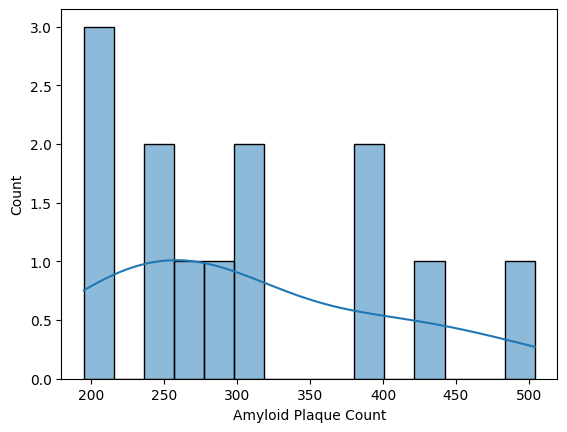

In [9]:
sns.histplot(data=sbc_df, x='Amyloid Plaque Count', bins=15, kde=True)

<Axes: xlabel='Total Amyloid IID', ylabel='Count'>

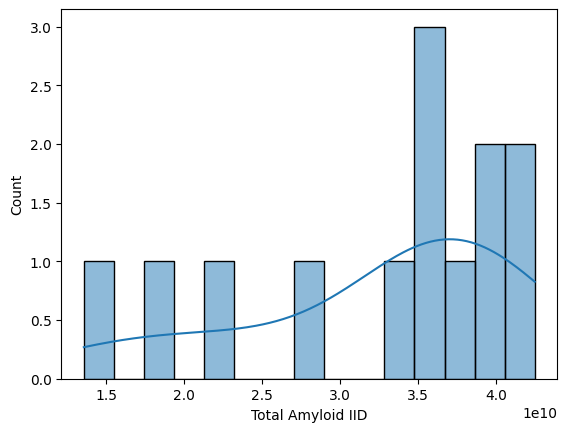

In [10]:
sns.histplot(data=sbc_df, x='Total Amyloid IID', bins=15, kde=True)

<Axes: xlabel='Microglia Count', ylabel='Count'>

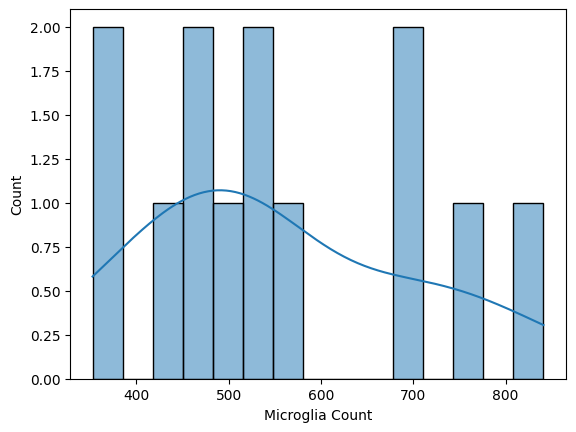

In [11]:
sns.histplot(data=sbc_df, x='Microglia Count', bins=15, kde=True)

<Axes: xlabel='Total Microglia IID', ylabel='Count'>

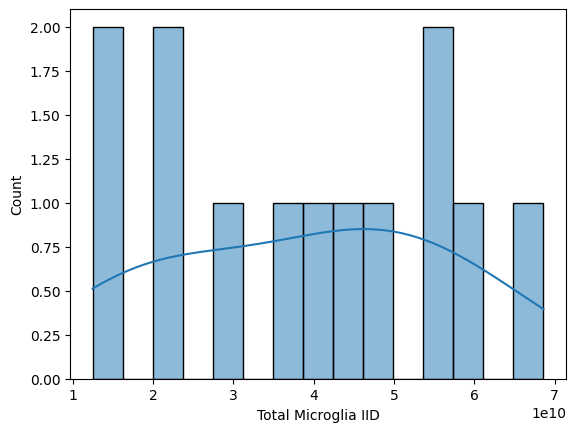

In [12]:
sns.histplot(data=sbc_df, x='Total Microglia IID', bins=15, kde=True)

<Axes: xlabel='LD Count', ylabel='Count'>

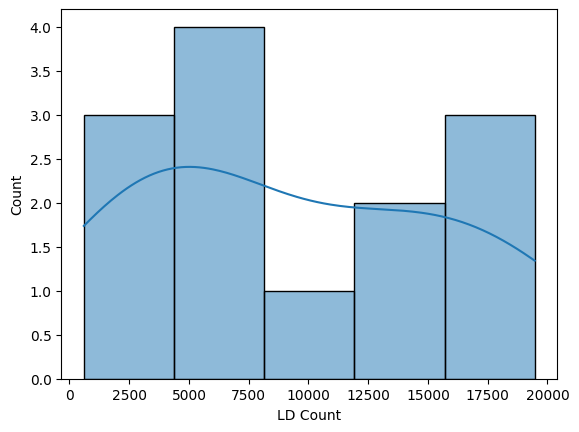

In [14]:
sns.histplot(x=sbc_df['LD Count'], kde=True)

<Axes: xlabel='BODIPY IID', ylabel='Count'>

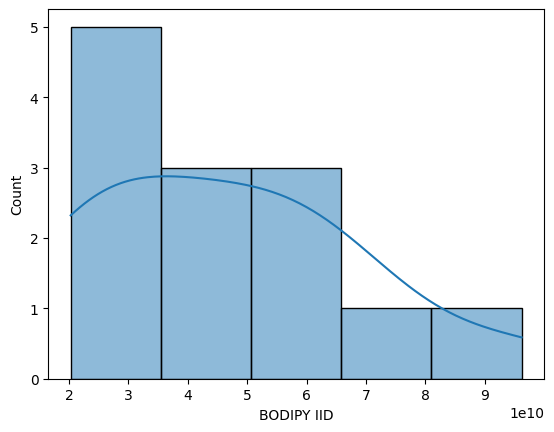

In [15]:
sns.histplot(x=sbc_df['BODIPY IID'], kde=True)

PearsonRResult(statistic=0.9738006505058995, pvalue=2.022444926824078e-08)

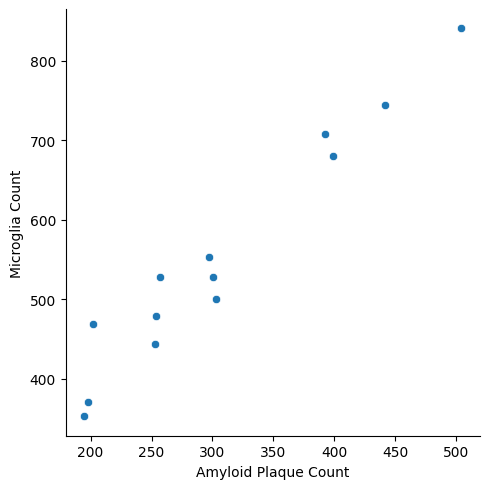

In [16]:
sns.relplot(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['Microglia Count'])
scipy.stats.pearsonr(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['Microglia Count'])

PearsonRResult(statistic=0.5999755537809329, pvalue=0.030179283957927655)

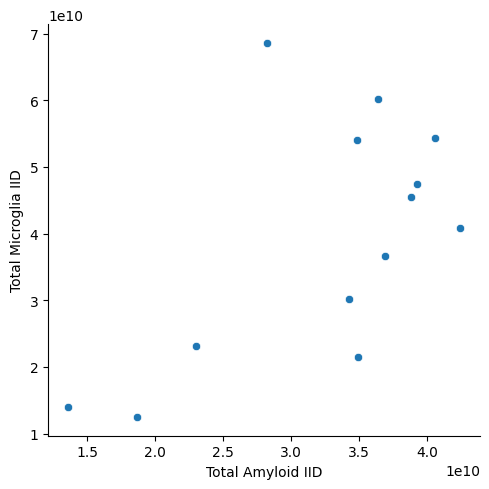

In [17]:
sns.relplot(x=sbc_df['Total Amyloid IID'], y=sbc_df['Total Microglia IID'])
scipy.stats.pearsonr(x=sbc_df['Total Amyloid IID'], y=sbc_df['Total Microglia IID'])

PearsonRResult(statistic=0.7792163694969045, pvalue=0.0016908932759803074)

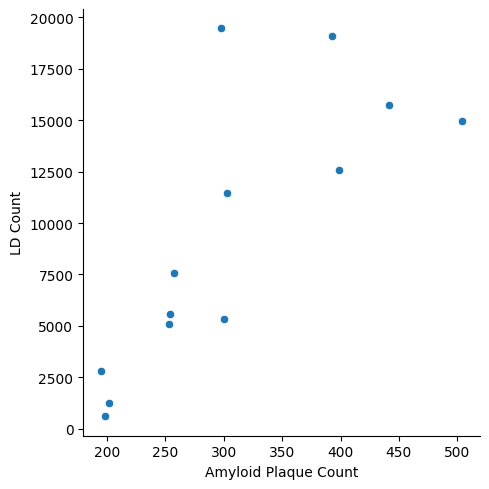

In [18]:
sns.relplot(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['LD Count'])
scipy.stats.pearsonr(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['LD Count'])

PearsonRResult(statistic=0.7814598688034664, pvalue=0.0016059979897380429)

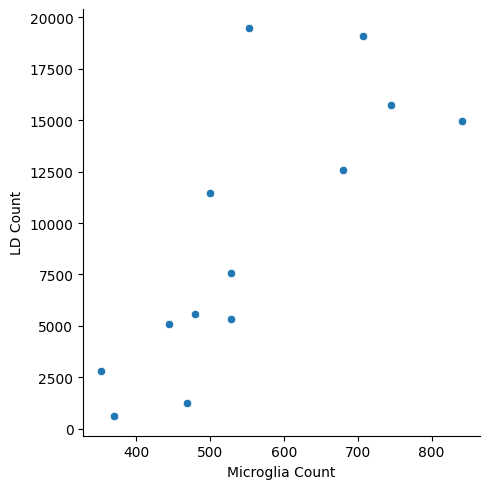

In [19]:
sns.relplot(x=sbc_df['Microglia Count'], y=sbc_df['LD Count'])
scipy.stats.pearsonr(x=sbc_df['Microglia Count'], y=sbc_df['LD Count'])